# Multimodality and Resampling

This notebook tests the robustness of modified Liu-West (MLW) resampling to multimodality in the posterior distribution. We use as a test the familiar model
$$
    \Pr(0 | \omega, t) = \cos^2(\omega t),
$$
exploiting that the likelihood function is *even* in $\omega$ to produce posteriors that always have exactly two modes. Because this structure is not explicitly added to the resampling, but is easy to reason about analytically, it serves as a nice test case.

## Preamble

As usual, we start by configuring division and enabling plotting support.

In [1]:
from __future__ import division, print_function
%matplotlib inline

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
try: plt.style.use('ggplot')
except: pass

In order to view the incredibly verbose output from resampler debugging, it is helpful to point Python's logging functionality at a file instead of printing it inside the notebook. We use ``tempfile`` to pick a directory in a cross-platform way.

In [3]:
import os, tempfile
logfile = os.path.join(tempfile.gettempdir(), 'multimodal_testing.log')
print("Logging to {}.".format(logfile))

import logging
logging.basicConfig(level=logging.DEBUG, filename=logfile)

Logging to /tmp/multimodal_testing.log.


Next, we import all the functionality from **QInfer** that we will need.

In [4]:
from qinfer.abstract_model import Model
from qinfer.test_models import SimplePrecessionModel
from qinfer.derived_models import BinomialModel
from qinfer.distributions import UniformDistribution
from qinfer.smc import SMCUpdater
from qinfer.resamplers import LiuWestResampler

/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/metrics.py:51: UserWarning: Could not import scikit-learn. Some features may not work.
  warnings.warn("Could not import scikit-learn. Some features may not work.")
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/home/cgranade/anaconda/envs/qinfer-binder/lib/python3.5/site-packages/qinfer/parallel.py:53: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


## Model and Prior Definition

We want the simple precession model $\cos^2(\omega t)$ to now extend over $\omega \in [-1, 1]$, so we redefine the ``are_models_valid`` method to allow for negative $\omega$.

In [5]:
class NotQuiteSoSimplePrecessionModel(SimplePrecessionModel):
    @staticmethod
    def are_models_valid(modelparams):
        return (np.abs(modelparams) <= 1)[:, 0]

Having done so, we now set a prior that explicitly includes the degeneracy in the likelihood.

In [6]:
model = NotQuiteSoSimplePrecessionModel()
prior = UniformDistribution([-1, 1])

In [7]:
def trial(a=0.98, h=None, track=True):
    true_params = prior.sample()
    updater = SMCUpdater(model, 1000, prior, resampler=LiuWestResampler(a=a, h=h, debug=True), track_resampling_divergence=track, debug_resampling=True)
    
    for idx_exp in range(100):
        exp = np.array([(9/8)**idx_exp], dtype=model.expparams_dtype)
        datum = model.simulate_experiment(true_params, exp)
        
        updater.update(datum, exp)
        
    # Since this model is always degenerate about the origin, take the mean
    # not of the original particles, but of the absolute value of the particles.
    updater.particle_locations = np.abs(updater.particle_locations)
        
    if track:
        return [true_params, updater.est_mean()], np.mean(updater.resampling_divergences)
    else:
        return [true_params, updater.est_mean()]

In [8]:
def corr(a=0.98, h=None, track=True, n_trials=100):
    trues = np.zeros((n_trials,))
    ests  = np.zeros((n_trials,))
    
    if track:
        divs = np.zeros((n_trials, ))
    
    for idx_trial in range(n_trials):
        if track:
            print(idx_trial, end=' ')
            (true, est), div = trial(a, h, track)
        else:
            true, est = trial(a, h, track)
        trues[idx_trial] = true
        ests[idx_trial] = est
        if track:
            divs[idx_trial] = div
    
    if track:
        return trues, ests, divs
    else:
        return trues, ests

In [9]:
trues, ests = corr(1, 0.02, False, 100)

In [10]:
bias = np.mean(np.abs(trues) - np.abs(ests))
risk = np.mean(np.abs(np.abs(trues) - np.abs(ests)))
print(bias, risk)

0.00506125533821 0.0125277128234


(0, 1)

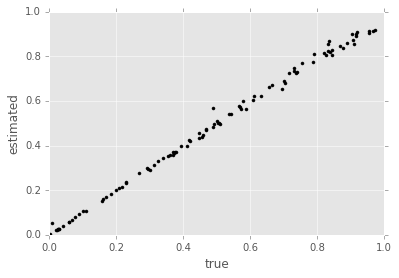

In [11]:
plt.plot(np.abs(trues), ests, 'k.')
plt.xlabel('true')
plt.ylabel('estimated')
plt.xlim((0, 1))
plt.ylim((0, 1))

In [12]:
trues, ests = corr(0.98, None, False, 100)
bias = np.mean(np.abs(trues) - np.abs(ests))
print(bias)

0.248851676669


(0, 1)

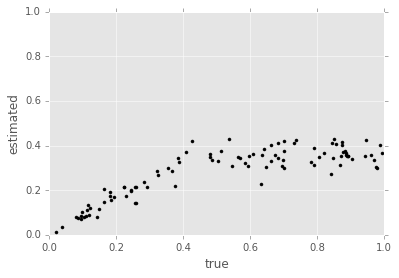

In [13]:
plt.plot(np.abs(trues), ests, 'k.')
plt.xlabel('true')
plt.ylabel('estimated')
plt.xlim((0, 1))
plt.ylim((0, 1))

## WIP: Mutliparameter Models

We also want to try with a multicos model, since that model admits a degeneracy between parameters that is broken by experimental variety. To arrive at a good estimate, then, a resampler must preserve unusual posterior structures that arise in the approach to a unimodal final posterior.

It's worth noting here that the traditional LW parameters work quite well for a better experimental protocol (choosing lots of varied experiments), but that this protocol may not always be available. Thus, MLW is a resource here to compensate for experimental restrictions.

In [14]:
class MultiCosModel(Model):
    
    def __init__(self, n_terms=2):
        self._n_terms = n_terms
        super(MultiCosModel, self).__init__()
    
    @property
    def n_modelparams(self):
        return self._n_terms
    
    @property
    def is_n_outcomes_constant(self):
        return True
    def n_outcomes(self, expparams):
        return 2
    
    def are_models_valid(self, modelparams):
        return np.all(np.logical_and(modelparams > 0, modelparams <= 1), axis=1)
    
    @property
    def expparams_dtype(self):
        return [('ts', '{}float'.format(self._n_terms))]
    
    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(MultiCosModel, self).likelihood(outcomes, modelparams, expparams)
        
        # Next, since we have a two-outcome model, everything is defined by
        # Pr(0 | modelparams; expparams), so we find the probability of 0
        # for each model and each experiment.
        #
        # We do so by taking a product along the modelparam index (len 2,
        # indicating omega_1 or omega_2), then squaring the result.
        pr0 = np.prod(
            np.cos(
                # shape (n_models, 1, 2)
                modelparams[:, np.newaxis, :] *
                # shape (n_experiments, 2)
                expparams['ts']
            ), # <- broadcasts to shape (n_models, n_experiments, 2).
            axis=2 # <- product over the final index (len 2)
        ) ** 2 # square each element
        
        # Now we use pr0_to_likelihood_array to turn this two index array
        # above into the form expected by SMCUpdater and other consumers
        # of likelihood().
        return Model.pr0_to_likelihood_array(outcomes, pr0)

In [15]:
mp_model = BinomialModel(MultiCosModel(3))
mp_prior = UniformDistribution([[0, 1]]*3)

In [16]:
def multicos_trial(a, h, n_exps=200):
    true = mp_prior.sample()
    mp_updater = SMCUpdater(mp_model, 2000, mp_prior,
        resampler=LiuWestResampler(a=a, h=h, debug=True),
        debug_resampling=True
    )
    
    while True:
        exp = np.array([(20 * np.pi * np.random.random(3), 40)], dtype=mp_model.expparams_dtype)
        # To test the resampler, we take data according to one experiment design until it has to resample, then switch.
        # Since the MLW resampler works quite well, we need to set an upper limit.
        for idx in range(500):
            datum = mp_model.simulate_experiment(true, exp)
            mp_updater.update(datum, exp)
            
            if len(mp_updater.data_record) >= n_exps:
                return true, mp_updater.est_mean()
            
            if mp_updater.just_resampled and idx >= 100:
                break
            

In [17]:
def nanmean(arr):
    return np.nansum(arr) / np.sum(np.isfinite(arr))

In [18]:
def mp_risk(a, h, n_trials=10, n_exps=200):
    mp_errors = np.empty((n_trials,))
    for idx_trial in range(n_trials):
        true, est = multicos_trial(a, h, n_exps)
        mp_errors[idx_trial] = np.sum((true - est)**2)
        
    n_nan = np.sum(np.isnan(mp_errors))
    if n_nan > 0:
        print("{} NaNs observed.".format(n_nan))
        
    return nanmean(mp_errors)